In [2]:
import numpy as np
import pytraj
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from pathlib import Path
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from scipy.stats import gaussian_kde
import mdtraj as md
from sklearn.neighbors import KernelDensity


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def build_restype_inds_dict(resnames):
    out = {}

    for i, resname in enumerate(resnames):
        out.setdefault(resname, []).append(i)

    return {resname: np.array(inds) for resname, inds in out.items()}


In [4]:

runs_dir = Path("../runs")

ref_pdb = runs_dir / "cg.pdb"
ref_dir = runs_dir / "ref"

u = mda.Universe(ref_pdb, guess_bonds=True)

unique_restypes = set(u.residues.resnames.tolist())

traj_dirs =  list(ref_dir.glob("[0-9]*"))

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [5]:
def check_inds(topo, phi_inds, psi_inds):
    resnames = [res.name for res in topo.residues][1:-1]

    for resname, phi, psi in zip(resnames, phi_inds[:-1], psi_inds[1:], strict=True):
        assert all(phi[1:] == psi[:-1])

        atom1 = topo.atom(phi[2])
        atom2 = topo.atom(psi[1])

        assert atom1 == atom2
        assert atom1.name == "CA"

        assert atom1.residue.name == atom2.residue.name == resname


def build_rama_angles(traj):
    phi_inds, phis = md.compute_phi(traj)
    psi_inds, psis = md.compute_psi(traj)

    check_inds(traj.topology, phi_inds, psi_inds)

    rama_angles = np.stack([phis[:, :-1], psis[:, 1:]], axis=-1).transpose([1, 0, 2])

    return rama_angles

def build_grid(angles, size=200):
    phi, psi = np.rollaxis(angles, 2)

    x_grid = np.linspace(phi.min() - 1e-5, phi.max() + 1e-5, size)
    y_grid = np.linspace(psi.min() - 1e-5, psi.max() + 1e-5, size)

    return np.stack(np.meshgrid(x_grid, y_grid, indexing="ij"), axis=-1).reshape(-1, 2)


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packag

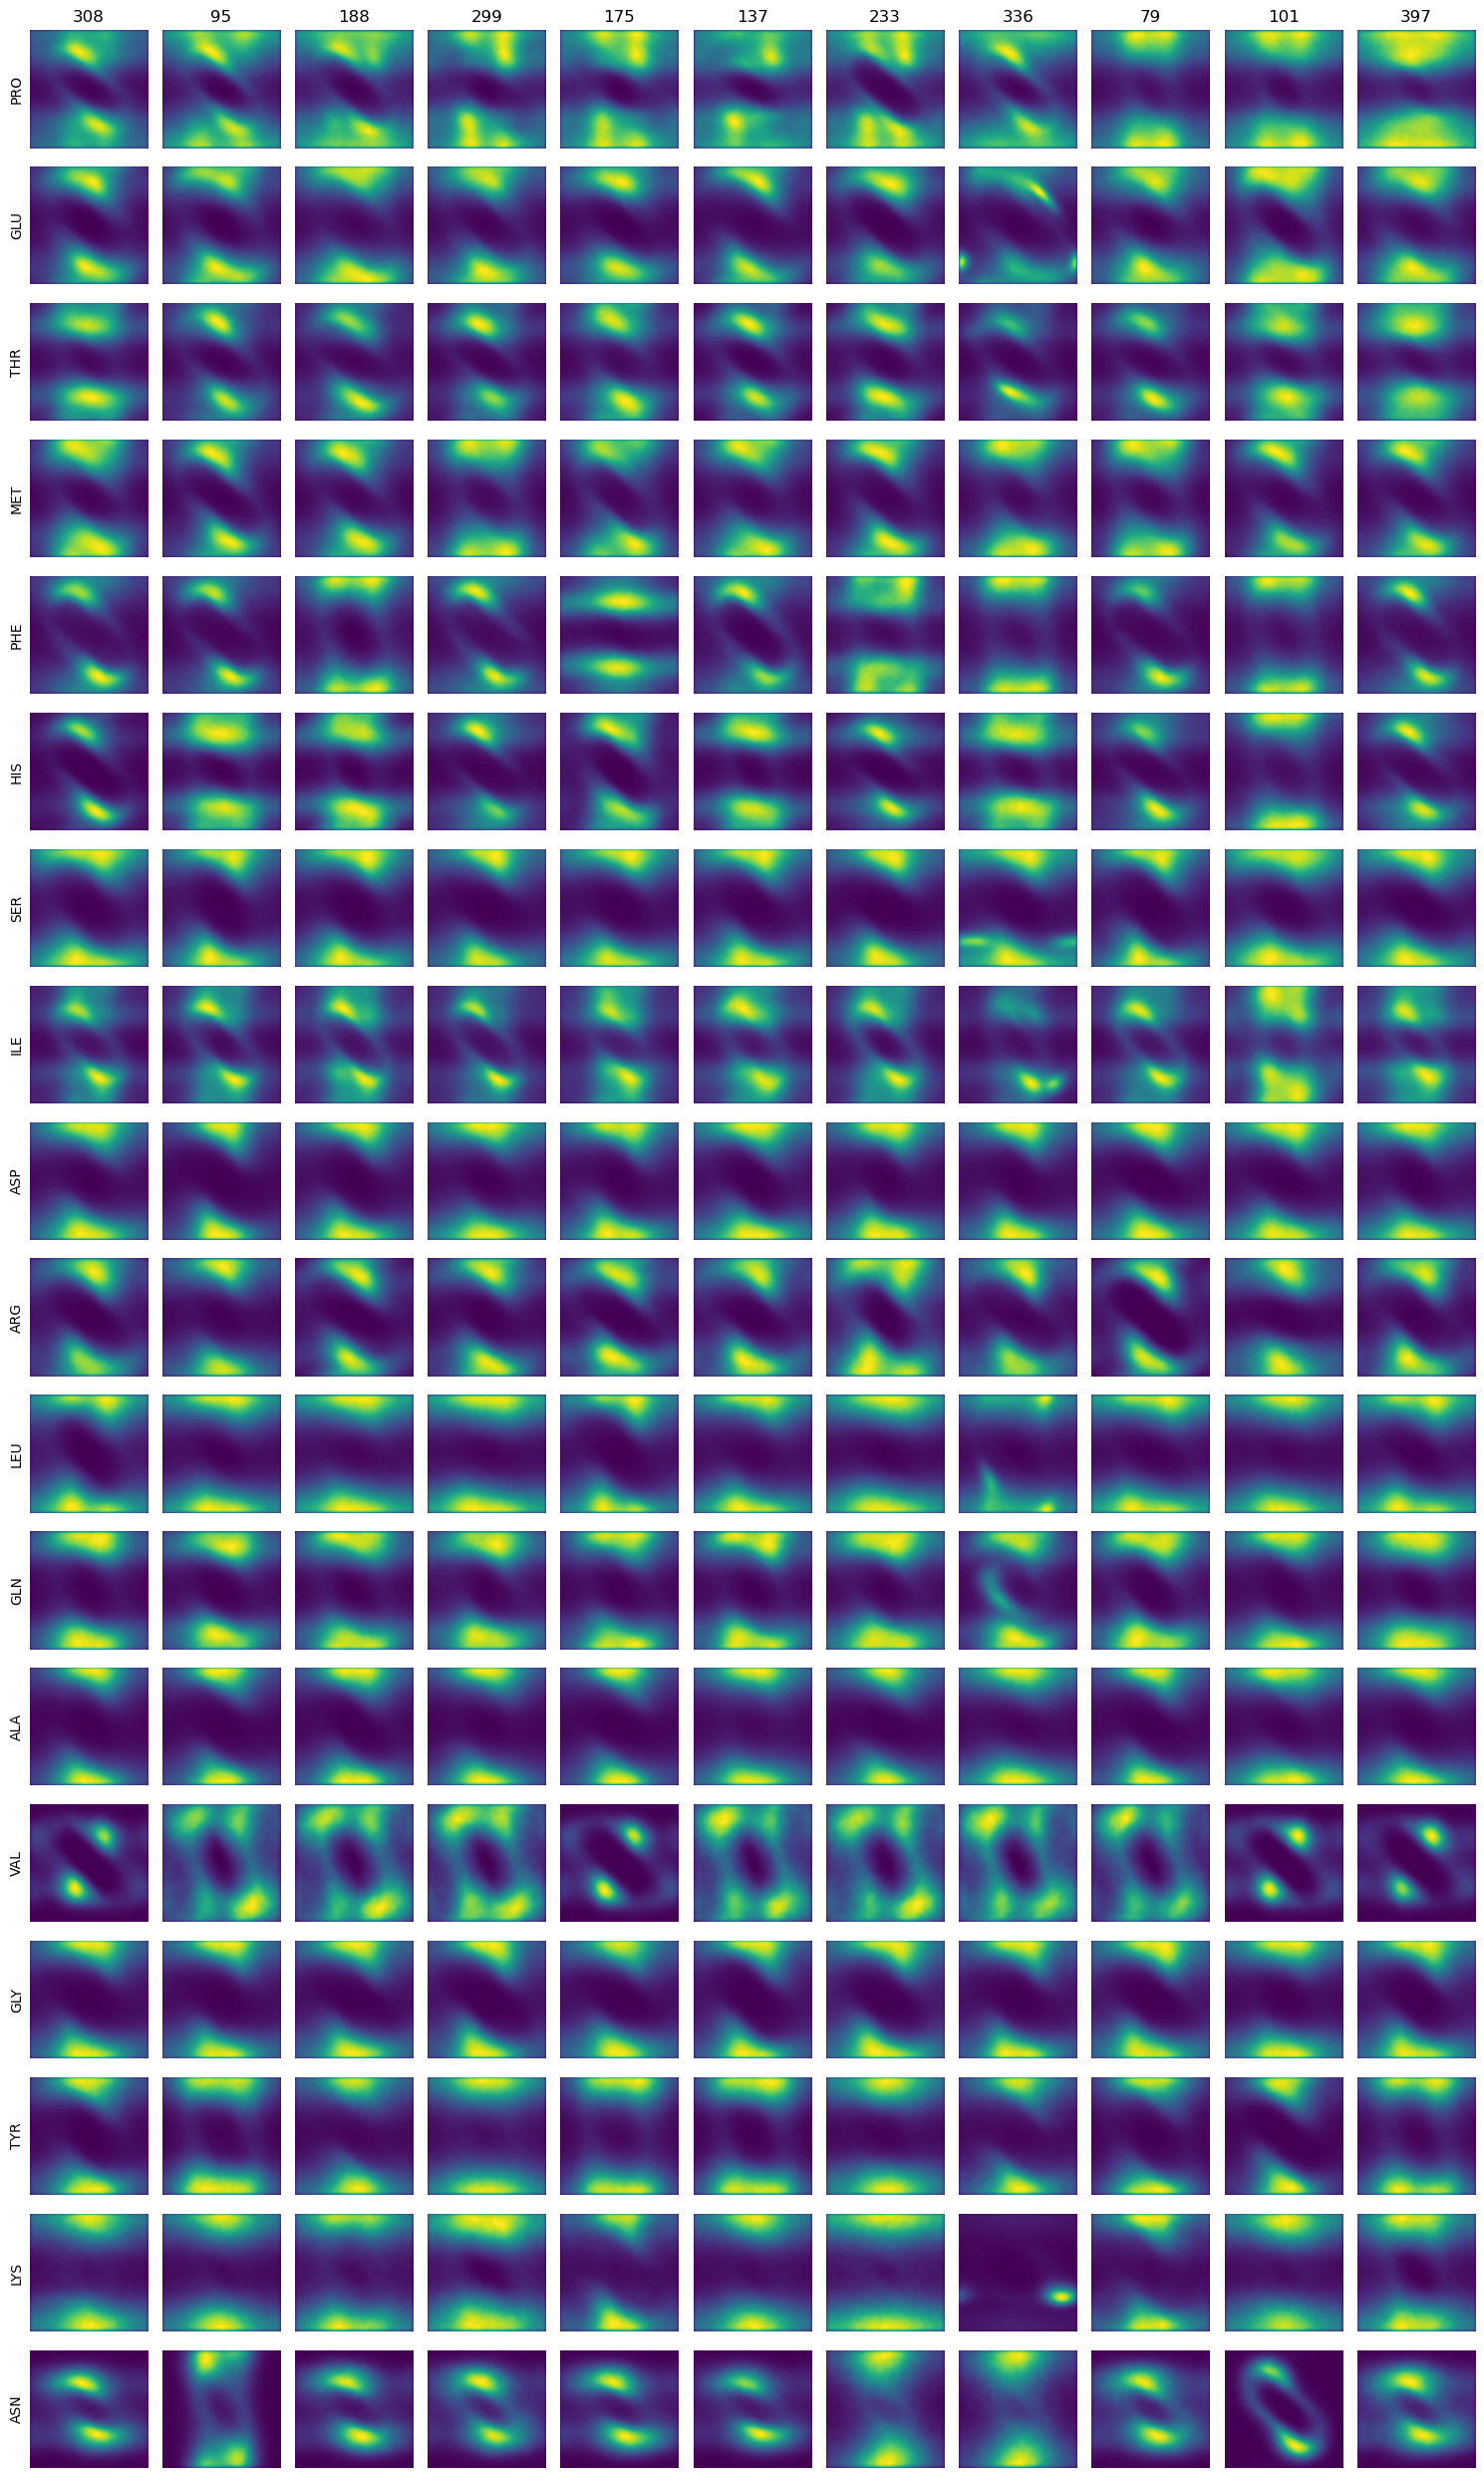

In [205]:
# angles = r.results.angles.transpose([1, 0, 2])
# restype_inds = build_restype_inds_dict(u.residues[1:-1].resnames)

# unique_restypes = set(res.name for res in traj.top.residues)

ratio = len(unique_restypes) / len(traj_dirs)

fig, axes = plt.subplots(
    nrows=len(unique_restypes), ncols=len(traj_dirs), figsize=(15, round(ratio * 15))
)

for ax in axes.flat:
    ax.axis("off")

for ax, d in zip(axes[0, :], traj_dirs, strict=True):
    ax.set_title(d.name)

for ax, resname in zip(axes[:, 0], unique_restypes, strict=True):
    ax.axis("on")
    ax.set_ylabel(resname)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["right", "left", "top", "bottom"]].set_visible(False)

for j, d in enumerate(traj_dirs):
    traj_file = d / "traj.xtc"

    traj = md.load(traj_file, top=ref_pdb)
    rama_angles = build_rama_angles(traj)

    grid = build_grid(rama_angles)

    resnames = [res.name for res in traj.top.residues][1:-1]
    restype_inds = build_restype_inds_dict(resnames)

    for i, (resname, inds) in enumerate(restype_inds.items()):
        ax = axes[i, j]

        restype_angles = rama_angles[inds].reshape(-1, 2)

        scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
        fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
        fft_kde.fit(restype_angles)
        pdf = fft_kde.evaluate(grid).reshape(200, 200)

        ax.imshow(pdf.T, origin="lower")

plt.tight_layout()

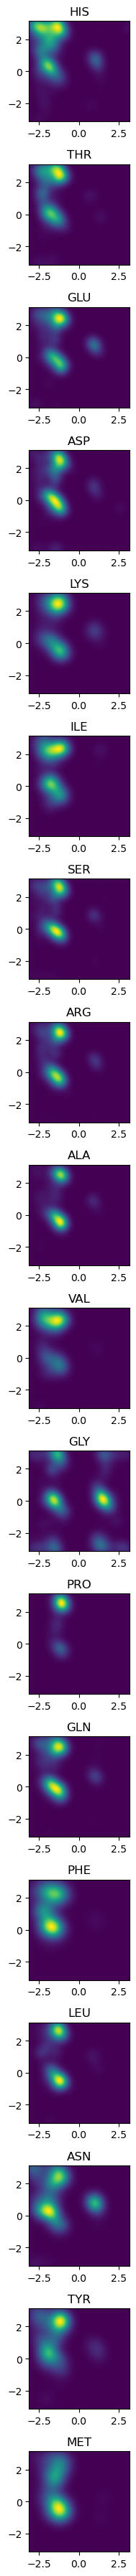

In [6]:
# ens_traj_path = "/data/vschnapka/202310-CMAP-HPS/MeV-NT/MeV_NT_ens/ensemble_200_1/ensemble_200_1.xtc"
ens_traj_path = "/data/gzappavigna/lmp_conf_builder/ensemble/ensemble.xtc"

ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/ensemble/5064a_132_CG.pdb")
ens_rama_angles = build_rama_angles(ens_traj)
grid = build_grid(ens_rama_angles)

unique_restypes = set(res.name for res in ens_traj.top.residues)
fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=1, figsize=(2, 2 * len(unique_restypes)))

resnames = [res.name for res in ens_traj.top.residues][1:-1]
restype_inds = build_restype_inds_dict(resnames)

for i,  (resname, inds) in enumerate(restype_inds.items()):
    ax = axes[i]

    restype_angles = ens_rama_angles[inds].reshape(-1, 2)

    scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
    fft_kde.fit(restype_angles)
    pdf = fft_kde.evaluate(grid).reshape(200, 200)
    # pdf = scipy_kde.evaluate(points.T).reshape(200, 200)

    ax.imshow(pdf.T, origin='lower', extent=[grid[:, 0].min(), grid[:, 0].max(), grid[:, 1].min(), grid[:, 1].max()])
    ax.set_title(resname)

plt.tight_layout()

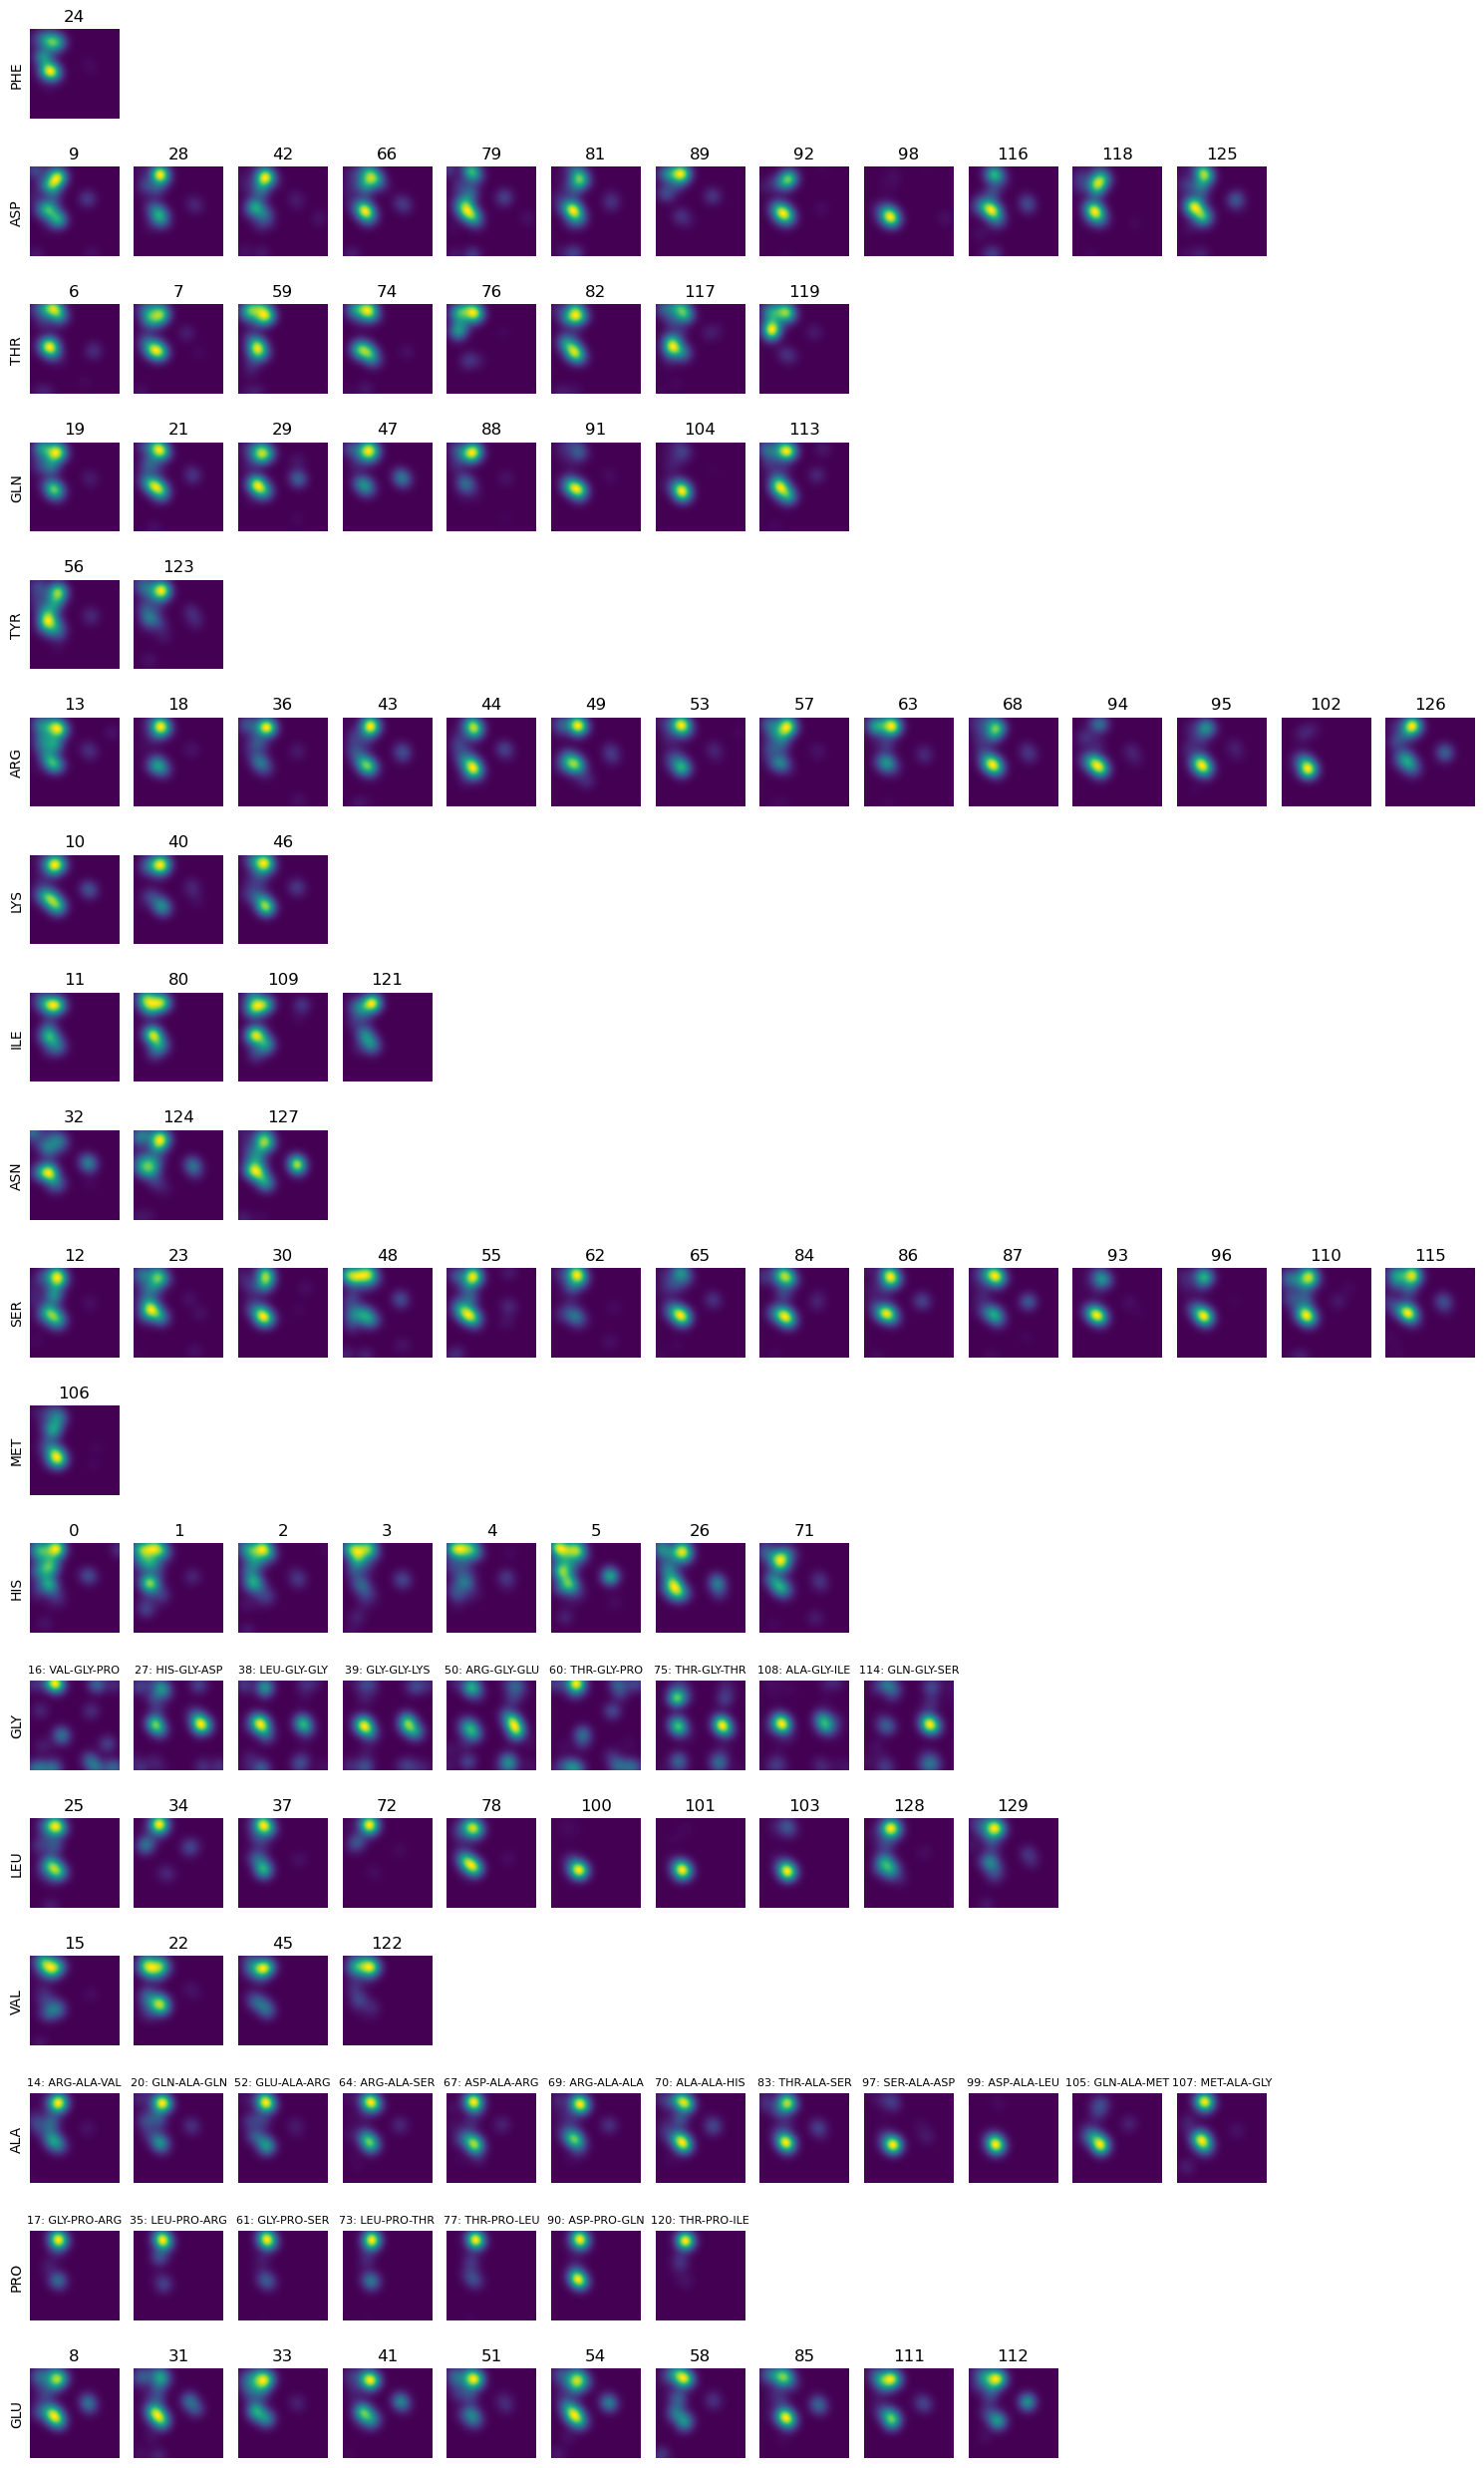

In [14]:
from collections import Counter

ens_traj_path = "/data/gzappavigna/lmp_conf_builder/ensemble/ensemble.xtc"

ens_traj = md.load(ens_traj_path, top="/data/gzappavigna/lmp_conf_builder/ensemble/5064a_132_CG.pdb")
ens_rama_angles = build_rama_angles(ens_traj)
grid = build_grid(ens_rama_angles)

resnames = [res.name for res in ens_traj.top.residues][1:-1]
c = Counter(resnames)
[(_, max_count)] =  c.most_common(1)

ratio = len(unique_restypes) / len(traj_dirs)
fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=max_count, figsize=(15, round(15 * ratio)))

for ax in axes.flat:
    ax.axis("off")

for ax, resname in zip(axes[:, 0], unique_restypes, strict=True):
    ax.axis("on")
    ax.set_ylabel(resname)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["right", "left", "top", "bottom"]].set_visible(False)

ax_its = {resname:iter(row) for resname, row in zip(unique_restypes, axes, strict=True)}

for i, resname in enumerate(resnames):
    ax = next(ax_its[resname])
    restype_angles = ens_rama_angles[i]

    scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
    fft_kde.fit(restype_angles)
    pdf = fft_kde.evaluate(grid).reshape(200, 200)

    ax.imshow(pdf.T, origin="lower")
    if resname in {"GLY", "PRO", "ALA"}:
        neigh = "-".join(resnames[i-1:i+2])
        ax.set_title(f"{i}: {neigh}", fontsize=8)
    else:
        ax.set_title(i)


for ax_it in ax_its.values():
    for ax in ax_it:
        fig.delaxes(ax)

plt.tight_layout()

In [1]:
traj_path = "/data/nsalvi/NT_HPS/test_4BR/ref_20210817/1/nopbc.dcd"
traj = md.load(traj_path, top="/data/nsalvi/NT_HPS/test_4BR/ref_20210817/1/CG.pdb")

unique_restypes = set(res.name for res in traj.top.residues)

rama_angles = build_rama_angles(traj)
grid = build_grid(rama_angles)

fig, axes = plt.subplots(nrows=len(unique_restypes), ncols=1, figsize=(2, 2 * len(unique_restypes)))

resnames = [res.name for res in traj.top.residues][1:-1]
restype_inds = build_restype_inds_dict(resnames)

for i,  (resname, inds) in enumerate(restype_inds.items()):
    ax = axes[i]

    restype_angles = rama_angles[inds].reshape(-1, 2)

    scipy_kde = gaussian_kde(restype_angles.T, bw_method="silverman")
    fft_kde = FFTKDE(bw=scipy_kde.silverman_factor())
    fft_kde.fit(restype_angles)
    pdf = fft_kde.evaluate(grid).reshape(200, 200)
    # pdf = scipy_kde.evaluate(points.T).reshape(200, 200)

    ax.imshow(pdf.T, origin="lower")
    ax.axis("off")
    ax.set_title(resname)

plt.tight_layout()


NameError: name 'md' is not defined